# Laboratory 5

- Pablo Cortés - 20.600.436-3
- Camilo Bravo - 21.048.333-0
- Rubén Rojas  - 20.441.846-2

### Import Required Libraries

In [1]:
import os

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (auc, classification_report, roc_auc_score,
                             roc_curve)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize

### Define Function to Load and Preprocess Images

Load images from subfolders representing each class. Resize images to 64x64 pixels, convert them to grayscale, normalize pixel values to [0, 1], and flatten them.

In [2]:
def load_images_from_folder(folder, size=(64, 64)):
    """
    Loads images from a specified folder, resizes them to a given size, and returns them as flattened array
    along with their labels.

    Args:
        folder (str): The path to the folder containing subfolders of images. Each subfolder represents a
                      different label.
        size (tuple, optional): The target size for resizing the images. Defaults to (64, 64).
    Returns:
        tuple: A tuple containing two numpy arrays:
            - images (numpy.ndarray): Array of flattened images.
            - labels (numpy.ndarray): Array of labels corresponding to the images.
    """
    images, labels = [], []
    for label, subfolder in enumerate(os.listdir(folder)):
        subfolder_path = os.path.join(folder, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_file in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                continue
            image = cv2.resize(image, size).flatten() / 255.0
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

### Load Dataset

Use the function to load the chess dataset from a directory. Each subfolder in the `dataset/Chess` directory represents a unique class.

In [3]:
dataset_folder = 'dataset/Chess'
images, labels = load_images_from_folder(dataset_folder)

### Encode Labels for Multi-Class Classification

Convert labels to a one-hot encoded format to enable multi-class classification.

In [4]:
labels = label_binarize(labels, classes=np.unique(labels))
n_classes = labels.shape[1]

### Split Data into Training and Testing Sets

Split the dataset into 80% training and 20% testing data.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42)

### Define a Function for Evaluation

Generate predictions, compute ROC-AUC, and plot ROC curves for each class.

In [6]:
def get_prediction_metrics(X_test, y_test, model):
    """
    Generate and display classification metrics and ROC curves for a multi-class model.
    This function prints the classification report, calculates the ROC curve and AUC for each class,
    and plots the multi-class ROC curve. The ROC curve plot is saved as "roc_curve.png".

    Args:
        X_test (array-like): Test features.
        y_test (array-like): True labels for the test set.
        model (object): Trained model with predict and predict_proba methods.

    Returns:
        None
    """
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, zero_division=1))

    y_score = np.array(model.predict_proba(X_test))
    y_score = np.array([class_probs[:, 1] for class_probs in y_score]).T

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.50)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-Class ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.savefig("roc_curve.png")

### Train the k-NN Classifier

Train a k-NN classifier using an arbitrary value of k.

In [7]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

### Evaluate the Model

Use the evaluation function to generate and display classification metrics and ROC curves.

              precision    recall  f1-score   support

           0       0.14      0.11      0.12        18
           1       0.44      0.15      0.22        27
           2       0.45      0.26      0.33        19
           3       0.80      0.25      0.38        16
           4       0.18      0.17      0.17        12
           5       0.00      0.00      0.00        19

   micro avg       0.32      0.15      0.21       111
   macro avg       0.34      0.16      0.21       111
weighted avg       0.34      0.15      0.21       111
 samples avg       0.68      0.15      0.15       111



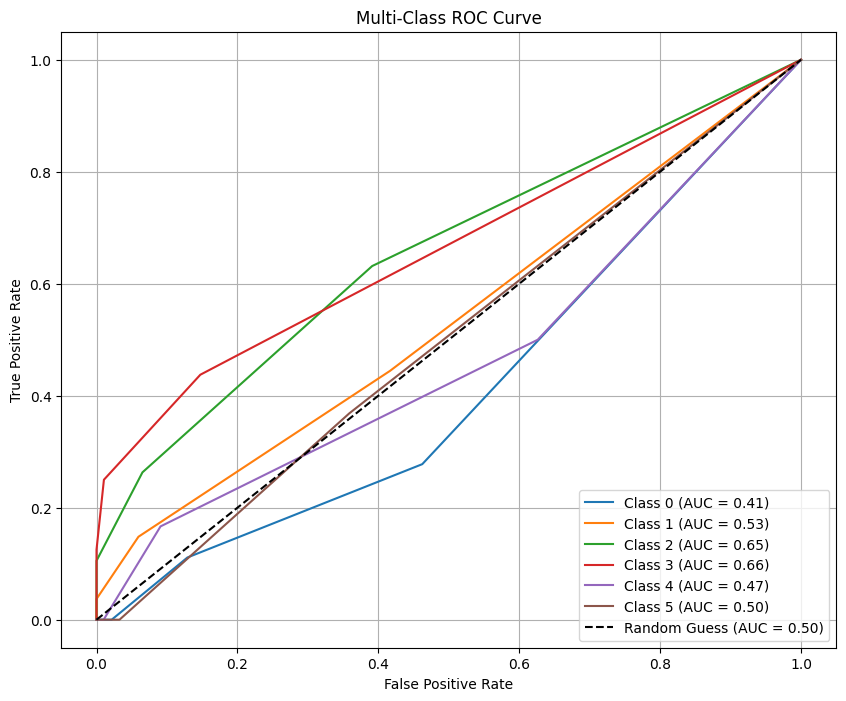

In [8]:
get_prediction_metrics(X_test, y_test, model)

### Hyperparameter Tuning with Grid Search

Use grid search to find the best combination of hyperparameters for k-NN, including `k`, weights, and distance metric.

In [9]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


### Train the k-NN Classifier with Optimal Hyperparameters

Train a k-NN classifier using the optimal hyperparameters obtained from grid search.

In [10]:
n_neighbors = grid_search.best_params_['n_neighbors']
weights = grid_search.best_params_['weights']
metric = grid_search.best_params_['metric']

model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
model.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

### Evaluate the Model with Optimal Hyperparameters

Use the evaluation function to generate and display classification metrics and ROC curves for the optimized k-NN classifier.

              precision    recall  f1-score   support

           0       0.07      0.06      0.06        18
           1       0.38      0.11      0.17        27
           2       0.30      0.16      0.21        19
           3       0.50      0.19      0.27        16
           4       0.08      0.08      0.08        12
           5       0.25      0.11      0.15        19

   micro avg       0.22      0.12      0.15       111
   macro avg       0.26      0.12      0.16       111
weighted avg       0.28      0.12      0.16       111
 samples avg       0.59      0.12      0.12       111



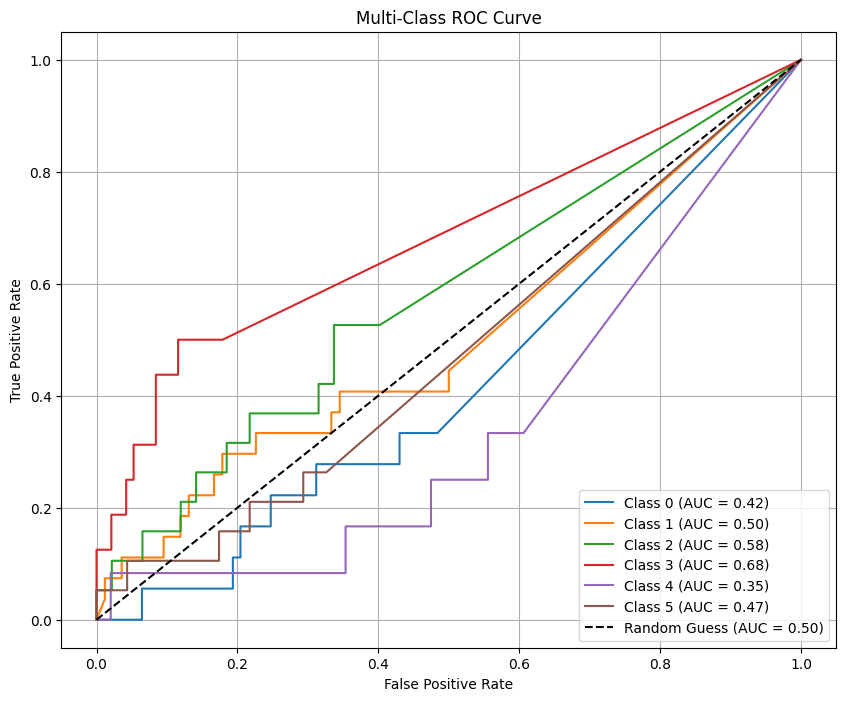

In [11]:
get_prediction_metrics(X_test, y_test, model)

### Apply PCA for Dimensionality Reduction

Fit PCA on the training data to find principal components. Transform both the training and test datasets to the reduced feature space.

In [12]:
n_components = 50

pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Original number of features: {X_train.shape[1]}")
print(f"Reduced number of features: {X_train_pca.shape[1]}")

Original number of features: 4096
Reduced number of features: 50


### Update Grid Search and Model Training

Use the reduced feature space for hyperparameter tuning and model training.

In [13]:
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(X_train_pca, y_train)
print("Best parameters after PCA:", grid_search.best_params_)

k = grid_search.best_params_['n_neighbors']
weights = grid_search.best_params_['weights']
metric = grid_search.best_params_['metric']

model = KNeighborsClassifier(n_neighbors=k, weights=weights, metric=metric)
model.fit(X_train_pca, y_train)

Best parameters after PCA: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}


KNeighborsClassifier(metric='euclidean', n_neighbors=3)

### Evaluate the Model with PCA

Evaluate the k-NN classifier trained on the PCA-reduced feature set.

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.33      0.04      0.07        27
           2       0.31      0.21      0.25        19
           3       0.57      0.25      0.35        16
           4       0.17      0.17      0.17        12
           5       0.00      0.00      0.00        19

   micro avg       0.22      0.10      0.14       111
   macro avg       0.23      0.11      0.14       111
weighted avg       0.23      0.10      0.13       111
 samples avg       0.65      0.10      0.10       111



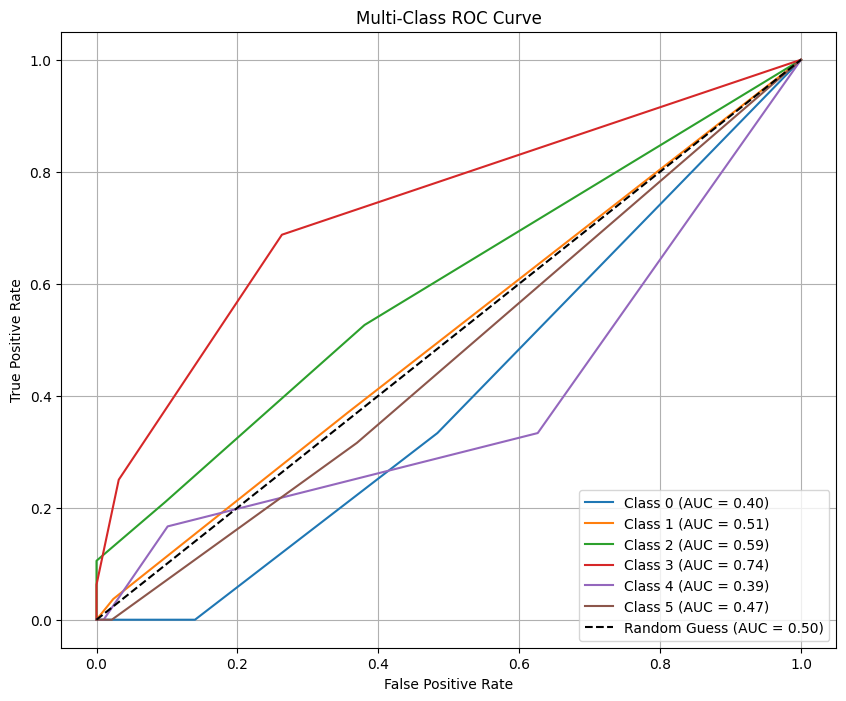

In [14]:
get_prediction_metrics(X_test_pca, y_test, model)

### Define Augmentation Pipeline

Use the `albumentations` library to create a pipeline for random transformations, such as flipping, rotation, brightness adjustments, and scaling.

In [15]:
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussianBlur(blur_limit=(3, 7), p=0.2),
    A.RandomScale(scale_limit=0.1, p=0.2),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2)
])

### Update Function to Load and Preprocess Images

Integrate the augmentation pipeline into the image loading and preprocessing function.

In [16]:
def load_images_from_folder(folder, size=(64, 64), augment_times=0):
    """
    Loads images from a specified folder, resizes them to a given size, and returns them as flattened array
    along with their labels.

    Args:
        folder (str): The path to the folder containing subfolders of images. Each subfolder represents a
                      different label.
        size (tuple, optional): The target size for resizing the images. Defaults to (64, 64).
        augment_times (int, optional): The number of times to augment each image. Defaults to 0.
    Returns:
        tuple: A tuple containing two numpy arrays:
            - images (numpy.ndarray): Array of flattened images.
            - labels (numpy.ndarray): Array of labels corresponding to the images.
    """
    images, labels = [], []
    for label, subfolder in enumerate(os.listdir(folder)):
        subfolder_path = os.path.join(folder, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        
        for image_file in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                continue
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, size)
            
            images.append(image.flatten())
            labels.append(label)
            
            for _ in range(augment_times):
                augmented = augmentation_pipeline(image=image)
                augmented_image = augmented['image']
                augmented_image = cv2.resize(augmented_image, size)
                
                images.append(augmented_image.flatten())
                labels.append(label)
    
    images = np.array(images)
    labels = np.array(labels)
    
    images = images / 255.0
    labels = label_binarize(labels, classes=np.unique(labels))
    
    return images, labels

### Load Dataset with Augmented Images

Use the updated function to load the chess dataset with augmented images.

In [17]:
images, labels = load_images_from_folder(dataset_folder, augment_times=2)

### Evaluate the Model with Augmented Images

Train and evaluate the k-NN classifier on the augmented dataset.

Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

              precision    recall  f1-score   support

           0       0.53      0.35      0.42        46
           1       0.55      0.41      0.47        73
           2       0.70      0.59      0.64        66
           3       0.89      0.46      0.61        69
           4       0.46      0.56      0.51        41
           5       0.68      0.55      0.61        38

   micro avg       0.62      0.48      0.54       333
   macro avg       0.63      0.49      0.54       333
weighted avg       0.65      0.48      0.55       333
 samples avg       0.71      0.48      0.48       333



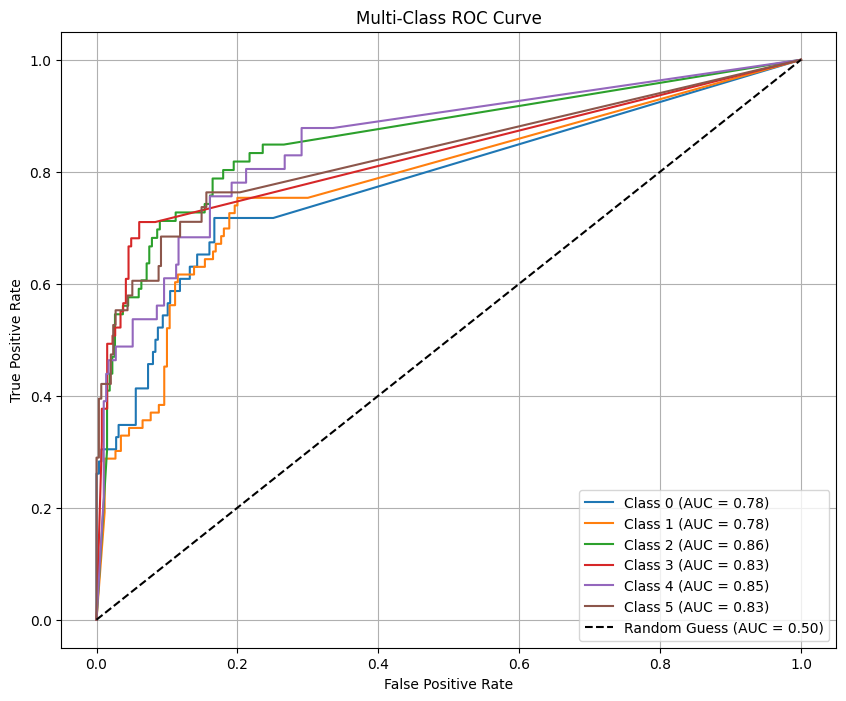

In [18]:
# 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42)

# Grid search
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}\n")

# Train k-NN classifier
n_neighbors = grid_search.best_params_['n_neighbors']
weights = grid_search.best_params_['weights']
metric = grid_search.best_params_['metric']

model = KNeighborsClassifier(n_neighbors=n_neighbors,
                           weights=weights, metric=metric)
model.fit(X_train, y_train)

# Evaluate classifier
get_prediction_metrics(X_test, y_test, model)

### Use Random Forest Classifier as Alternative Model

In [ ]:
# Hyperparameter optimization for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}
grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42), param_grid, cv=5)
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [20]:
print(f"Best parameters: {grid_search_rf.best_params_}\n")

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}



              precision    recall  f1-score   support

           0       1.00      0.15      0.26        46
           1       0.93      0.18      0.30        73
           2       1.00      0.30      0.47        66
           3       0.92      0.32      0.47        69
           4       0.89      0.20      0.32        41
           5       1.00      0.26      0.42        38

   micro avg       0.95      0.24      0.38       333
   macro avg       0.96      0.24      0.37       333
weighted avg       0.95      0.24      0.38       333
 samples avg       0.99      0.24      0.24       333



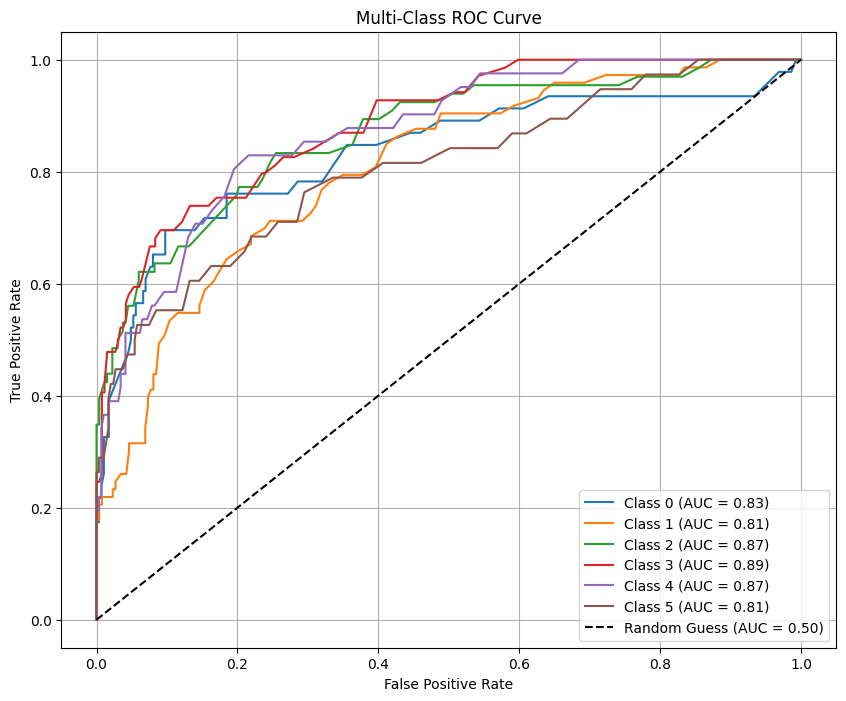

In [21]:
rf_best = grid_search_rf.best_estimator_

get_prediction_metrics(X_test, y_test, rf_best)